<h1><center> Analisi della distribuzione di miscentering di ammassi eROSITA</center></h1>
<h3><center>Cristina Alina Goga</center></h3>

## 1. Introduzione

Di seguito si è implementato un codice Python per l'analisi della distribuzione degli offset tra i
centri degli ammassi di galassie osservati in banda X e in banda ottica, utilizzando la prima data release della survey eROSITA (febbraio 2024). Per descrivere la miscentering distribution vengono proposti e studiati il Modello S15 (Saro et al. 2015) ed il Modello Z19 (Zhang et al. 2019).

## 2. Analisi del catalogo 

In [816]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emcee
from scipy.optimize import minimize
from getdist import plots, MCSamples
import pygtc
from scipy.stats import chi2
import warnings
warnings.filterwarnings('ignore')

#Si definiscono le funzioni che utilizzò in seguito: i due modelli per la distribuzione dei dati 
#analizzati,e per entrambi vengono implementate le prior, likelihood e posterior distribution per
#l'analisi bayesiana.

def model_S15(theta, x):
    
    '''    Modello S15 per la descrizione della miscentering distribution.
    Argomenti
    ----------------
    theta: array_like, 3 componenti, in ordine i parametri  rho, sigma_0 e sigma_1 da cui dipende
           il modello
    x: array_like, valori di offset per cui viene valutata la probability distribution function

    Risultato
    ----------------
    Il valore atteso della probability distribution function, secondo il modello.'''
    
    rho, s0,s1 = theta
    return rho*(x/(s0**2))*np.exp(-0.5*(x/s0)**2)+(1-rho)*(x/(s1**2))*np.exp(-0.5*(x/s1)**2)

def model_Z19(theta,x):
    '''    Modello Z19 per la descrizione della miscentering distribution.
    Argomenti
    ----------------
    theta: array_like, 3 componenti, in ordine i parametri  rho, sigma_0 e sigma_1 da cui dipende
           il modello
    x: array_like, valori di offset per cui viene valutata la probability distribution function

    Risultato
    ----------------
    Il valore atteso della probability distribution function, secondo il modello.'''
    rho, s0, s1 = theta
    return (rho/s0)*np.exp(-x/s0)+(1-rho)*(x/(s1**2))*np.exp(-x/s1)

def log_prior(theta):
    ''' Calcola il logaritmo della prior distribution dei parametri della miscentering distribution, 
    assumenta essere piatta per valori positivi di sigma_0 e sigma_1 e per rho compreso tra 0 e 1
    inclusi.
    
    Argomenti
    ----------------
    theta: array_like, 3 componenti, in ordine i parametri  rho, sigma_0 e sigma_1 da cui dipendono
           i modelli
           
    Risultato
    ----------------
    Il logaritmo della prior distribution.'''
    rho, s0, s1 = theta
    if  0<=rho<=1 and s0>0  and s1>0:
        return  0.0
    return -np.inf

def log_likelihood_S15(theta, x):
    '''    Calcola il logaritmo della funzione di likelihood, assumendo il modello S15 per la descrizione 
    dei dati.
    
    Argomenti
    ----------------
    theta: array_like, 3 componenti, in ordine i parametri  rho, sigma_0 e sigma_1 da cui dipende
           il modello
           
    x: array_like, valori di offset per cui viene valutata la likelihood.
           
    Risultato
    ----------------
    Il logaritmo della della funzione di likelihood. '''
    rho, s0, s1 = theta
    return np.nansum(np.log(model_S15(theta ,x)))

def log_likelihood_Z19(theta, x):
    '''    Calcola il logaritmo della funzione di likelihood, assumendo il modello Z19 per la descrizione 
    dei dati.
    
    Argomenti
    ----------------
    theta: array_like, 3 componenti, in ordine i parametri  rho, sigma_0 e sigma_1 da cui dipende
           il modello
           
    x: array_like, valori di offset per cui viene valutata la likelihood.
           
    Risultato
    ----------------
    Il logaritmo della funzione di likelihood. '''
    rho, s0, s1 = theta
    return np.nansum(np.log(model_Z19(theta ,x)))   

def log_posterior_S15(theta, x):
    '''    Calcola il logaritmo della posterior distribution, assumendo il modello S15 per la descrizione 
    dei dati.
    
    Argomenti
    ----------------
    theta: array_like, 3 componenti, in ordine i parametri  rho, sigma_0 e sigma_1 da cui dipende
           il modello
           
    x: array_like, valori di offset per cui viene valutata la posterior distribution.
           
    Risultato
    ----------------
    Il logaritmo della posterior distribution. '''
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_S15(theta, x)

def log_posterior_Z19(theta, x):
    '''Calcola il logaritmo della funzione di likelihood, assumendo il modello Z19 per la descrizione 
    dei dati.
    
    Argomenti
    ----------------
    theta: array_like, 3 componenti, in ordine i parametri  rho, sigma_0 e sigma_1 da cui dipende
           il modello
           
    x: array_like, valori di offset per cui viene valutata la posterior distribution.
           
    Risultato
    ----------------
    Il logaritmo della posterior distribution. '''
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_Z19(theta, x)

data = pd.read_csv('catalog_selected_columns_filtered_with_cluster_index.csv') 

Si legge il catalogo 'catalog_selected_columns_filtered_with_cluster_index.csv' e si costruisce un istogramma con le misure di distanza normalizzata. Si usa la scala logaritmica in ascissa per miglior visibilità.

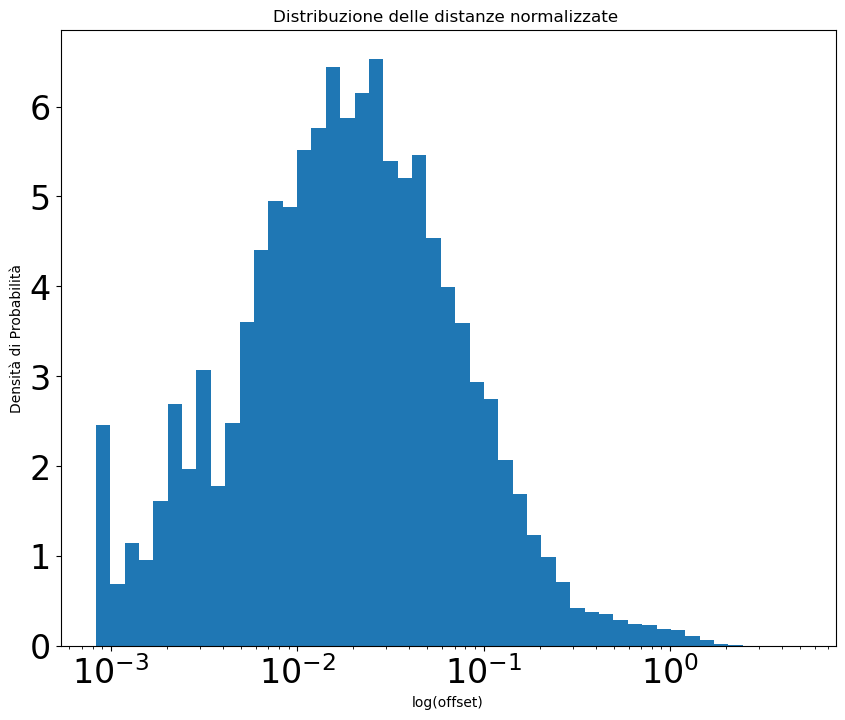

In [888]:
x=np.logspace(np.log10(np.min(data["BCG_offset_R500"])),np.log10(5), 50)
#x=np.arange(0,5,0.1)
plt.figure(figsize=(10,8))
plt.hist(data["BCG_offset_R500"], x, density=True)
#plt.hist(data["BCG_offset_R500"], x)
plt.xscale('log')
plt.xlabel("log(offset)")
plt.ylabel("Densità di Probabilità")
plt.title("Distribuzione delle distanze normalizzate ")
plt.show()


Per studiare la dipendenza della distribuzione dalla massa (espressa come logaritmo della
massa dell’ammasso di galassie in unità di massa solare) si suddividono i dati raccolti in sottocampioni in base alla massa e si confrontano gli istogrammi così ottenuti. Lo stesso procedimento viene ripetuto per analizzare la dipendenza dal redshift.

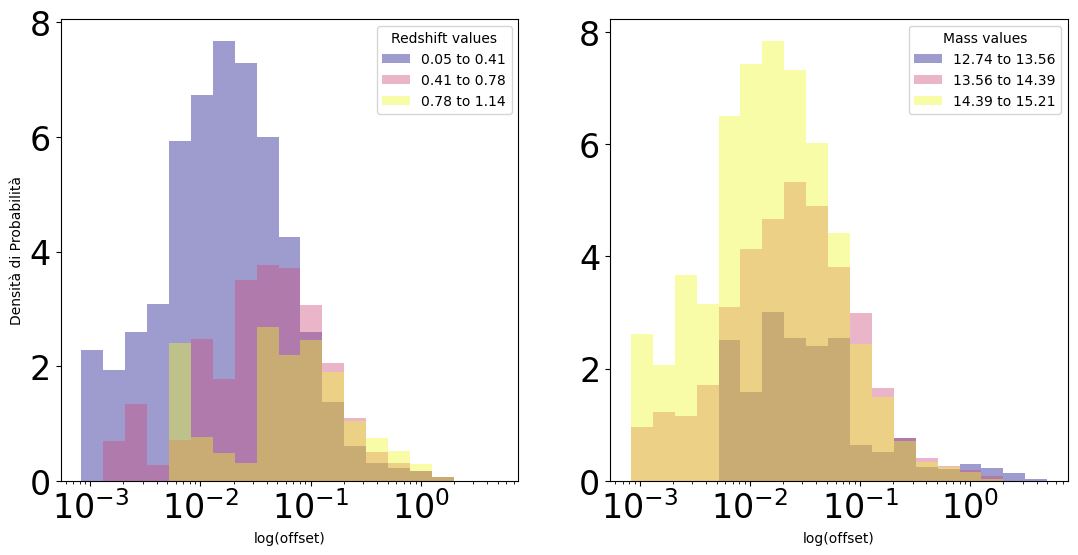

In [822]:
plt.figure(figsize=(13, 6))
plt.subplot(1, 2, 1)

Nbins = 3
bins = pd.cut(data["BEST_Z"], bins=Nbins) #Si suddividono i dati raccolti in Nbins gruppi in base al
#valore di redshift

cmap = plt.cm.get_cmap('plasma', Nbins)  
x=np.logspace(np.log10(np.min(data["BCG_offset_R500"])),np.log10(5), 20)

for i, (bin_value, group) in enumerate(data.groupby(bins)):
    color = cmap(i / (Nbins - 1))  
    plt.hist( group["BCG_offset_R500"],x,label=f'{bin_value.left:.2f} to {bin_value.right:.2f}',color=color, density=True, alpha=0.4)

plt.legend()
plt.plot()
plt.xscale("log")  
plt.xlabel("log(offset)")  
plt.ylabel("Densità di Probabilità")
plt.legend(title='Redshift values')

bins = pd.cut(data["logM500"], bins=Nbins) #Si suddividono i dati raccolti in Nbins gruppi in base al
#valore di massa

plt.subplot(1, 2, 2)
for i, (bin_value, group) in enumerate(data.groupby(bins)):
    color = cmap(i / (Nbins - 1))  
    plt.hist( group["BCG_offset_R500"],x,label=f'{bin_value.left:.2f} to {bin_value.right:.2f}',color=color, density=True, alpha=0.4)

plt.legend(title='Mass values') 
plt.plot()
plt.xscale("log")              
plt.xlabel("log(offset)")  

plt.show()

Si nota come all'aumentare del redshift, il massimo della distribuzione diminuisce, e i valori di offset aumentanp. Viceversa, all'aumentare della massa dell'ammasso di galassie, il massimo della distribuzione aumenta, e i valori di offset diminuiscono. 

## 3. Sviluppo dei modelli

Per predire la distribuzione osservata di distanza normalizzata x tra
il centro determinato in banda X ed il centro determinato in banda ottica si
considerano i seguenti due modelli, dove una frazione $\rho$ di ammassi ben centrati viene
descritta dal parametro $\sigma_0$, ed una frazione 1−$\rho$  di ammassi centrati erroneamente viene
descritta dal parametro $\sigma_1$.

### Modello S15 (Saro et al. 2015)

$$
P(x|\rho,\sigma_0, \sigma_1) = \rho \cdot \frac{x}{\sigma_0^2} \cdot exp\left(-0.5 \cdot \left(\frac{x}{\sigma_0}\right)^2\right)+(1-\rho)\cdot \frac{x}{\sigma_1^2} \cdot exp\left(-0.5 \cdot \left(\frac{x}{\sigma_1}\right)^2\right)
$$

### Modello Z19 (Zhang et al. 2019)

$$
P(x|\rho,\sigma_0, \sigma_1) = \rho \cdot \frac{1}{\sigma_0} \cdot exp\left(\frac{x}{\sigma_0}\right)+(1-\rho)\cdot \frac{x}{\sigma_1^2} \cdot exp\left(-\frac{x}{\sigma_1}\right)
$$

Per studiare la dipendenza dai parametri, vengono fatti variare uno alla volta tenendo fissi gli altri due. Gli intervalli considerati per la variazione sono scelti sulla base di considerazioni sul significato fisico dei paratrei. $\rho$ è una frazione di ammassi e perciò può assumere valori solo tra 0 e 1. Il modello S15 è una funzione pari dei parametri $\sigma_0$ e $\sigma_1$, per semplicità li si scelgono positivi (non possono annullarsi in quanto la funzione divergerebbe). Per quanto riguarda il modello Z19, invece, questa scelta è obbligata in quanto la funzione diverge per valori non positivi di $\sigma_0$ e $\sigma_1$. Per l'analisi si tiene conto solo dei valori positivi per x, poichè rappresenta una distanza.

### 3.1 Modello S15

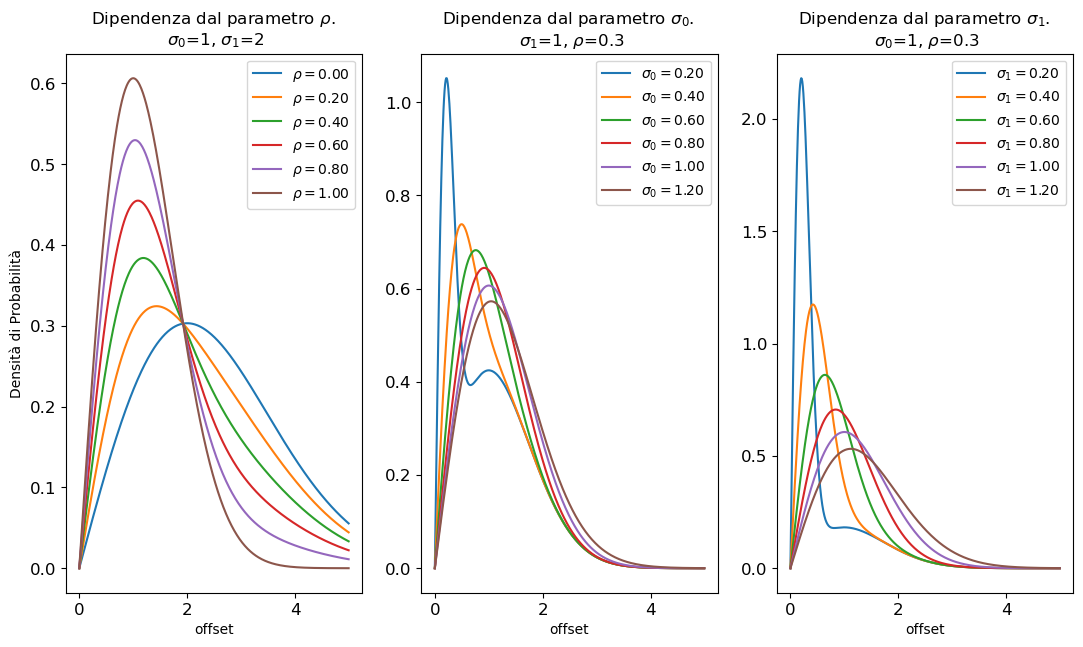

In [827]:
#xarr=np.logspace(np.log10(np.min(data["BCG_offset_R500"])),np.log10(5), 1000)

xarr=np.arange(0,5,0.01) 
fig, axes = plt.subplots(1,3, figsize=(13, 7))

n=6

cmap = plt.cm.get_cmap('plasma', n)  

for i in range(n): #Si fanno variare i parametri in manira uniforme, uno alla volta tenendo gli altri
                   #due fissi
    color = cmap(i / (n - 1)) 
    axes[0].plot(xarr, model_S15([0.2*(i),1,2], xarr), label=r"$\rho={0:.2f}$".format(0.2*(i)))
    axes[1].plot(xarr, model_S15([0.3,0.2*(i+1),1], xarr), label=r"$\sigma_0={0:.2f}$".format(0.2*(i+1))) 
    axes[2].plot(xarr, model_S15([0.3,1,0.2*(i+1)], xarr), label=r"$\sigma_1={0:.2f}$".format(0.2*(i+1)))

for i in range(3):
    axes[i].set_xlabel("offset")
    axes[i].legend()
    axes[i].tick_params(axis='both', which='major', labelsize=12)
#    axes[i].set_xscale("log")



axes[0].set_ylabel("Densità di Probabilità")
axes[0].set_title('Dipendenza dal parametro {}. \n {}=1, {}=2 '.format(r"$\rho$", r"$\sigma_0$", "$\sigma_1$"))
axes[1].set_title('Dipendenza dal parametro {1}. \n {2}=1, {0}=0.3 '.format(r"$\rho$", r"$\sigma_0$", "$\sigma_1$"))
axes[2].set_title('Dipendenza dal parametro {2}. \n {1}=1, {0}=0.3 '.format(r"$\rho$", r"$\sigma_0$", "$\sigma_1$"))


plt.show()

### 3.2 Modello Z19

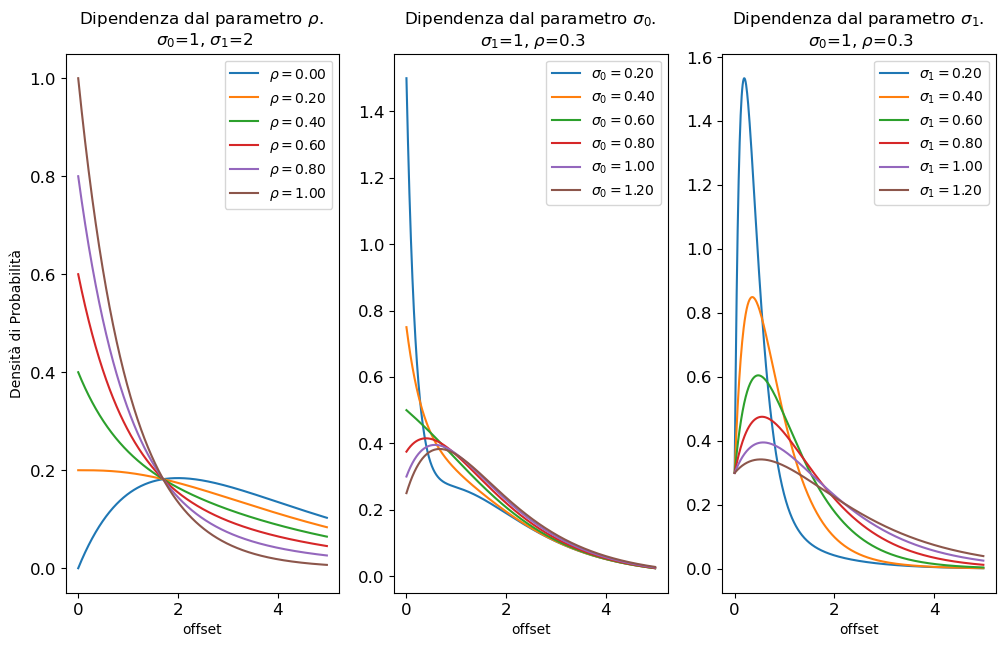

In [830]:
#xarr=np.logspace(np.log10(np.min(data["BCG_offset_R500"])),np.log10(5), 1000)

xarr=np.arange(0,5,0.01) 
fig, axes = plt.subplots(1,3, figsize=(12, 7))

n=6

cmap = plt.cm.get_cmap('plasma', n)  

for i in range(n): #Si fanno variare i parametri in manira uniforme, uno alla volta tenendo gli altri
#due fissi
    color = cmap(i / (n - 1)) 
    axes[0].plot(xarr, model_Z19([0.2*(i),1,2], xarr), label=r"$\rho={0:.2f}$".format(0.2*(i)))
    axes[1].plot(xarr, model_Z19([0.3,0.2*(i+1),1], xarr), label=r"$\sigma_0={0:.2f}$".format(0.2*(i+1))) 
    axes[2].plot(xarr, model_Z19([0.3,1,0.2*(i+1)], xarr), label=r"$\sigma_1={0:.2f}$".format(0.2*(i+1)))

for i in range(3):
    axes[i].set_xlabel("offset")
    axes[i].legend()
    axes[i].tick_params(axis='both', which='major', labelsize=12)
#    axes[i].set_xscale("log")



axes[0].set_ylabel("Densità di Probabilità")
axes[0].set_title('Dipendenza dal parametro {}. \n {}=1, {}=2 '.format(r"$\rho$", r"$\sigma_0$", "$\sigma_1$"))
axes[1].set_title('Dipendenza dal parametro {1}. \n {2}=1, {0}=0.3 '.format(r"$\rho$", r"$\sigma_0$", "$\sigma_1$"))
axes[2].set_title('Dipendenza dal parametro {2}. \n {1}=1, {0}=0.3 '.format(r"$\rho$", r"$\sigma_0$", "$\sigma_1$"))


plt.show()

## 4. Analisi Bayesiana
L'approccio bayesiano alla stima dei parametri consiste nell'utilizzare l'equatione di Bayes per "aggiornare" la probabilità a priori dei parametri p di un certo modello P(p|M), sfruttando la probabilità di ottenere un certo set di dati d fissando i parametri P(d|pM).
$$
P(p|d M) = \frac{P(d|p M) \cdot P(p|M)}{P(d|M)}
$$

Utilizzando l'algoritmo emcee si ottengono le posterior distribution per i parametri, a partire dai dati a disposizione. Si procede separatamente per i due modelli. In entrambi i casi si assumono distribuzioni a priori piatte per i valori che possono assumere, tenendo conto delle considerazioni precedenti. Il fattore P(d|M), essendo indipendente dai parametri viene trascurato a questo livello di analisi. 

### 4.1 Modello S15

In [833]:
np.random.seed(42)
nll = lambda *args: -log_posterior_S15(*args)
initial = np.array([0.5, 1.,1.])
soln = minimize(nll, initial, args=data.BCG_offset_R500) 
rho_bf, s0_bf, s1_bf = soln.x

pos = soln.x *(1+ 1e-2 * np.random.randn(32, 3))  #definisco la posizione iniziale nello spazio
                                                  #dei parametri
nwalkers, ndim = pos.shape   # numero di walker e di parametri da fittare
sampler = emcee.EnsembleSampler( nwalkers, ndim, log_posterior_S15, args=(data["BCG_offset_R500"],))
sampler.run_mcmc(pos, 3000, progress=True);

100%|███████████████████████████████████████| 3000/3000 [00:37<00:00, 80.79it/s]


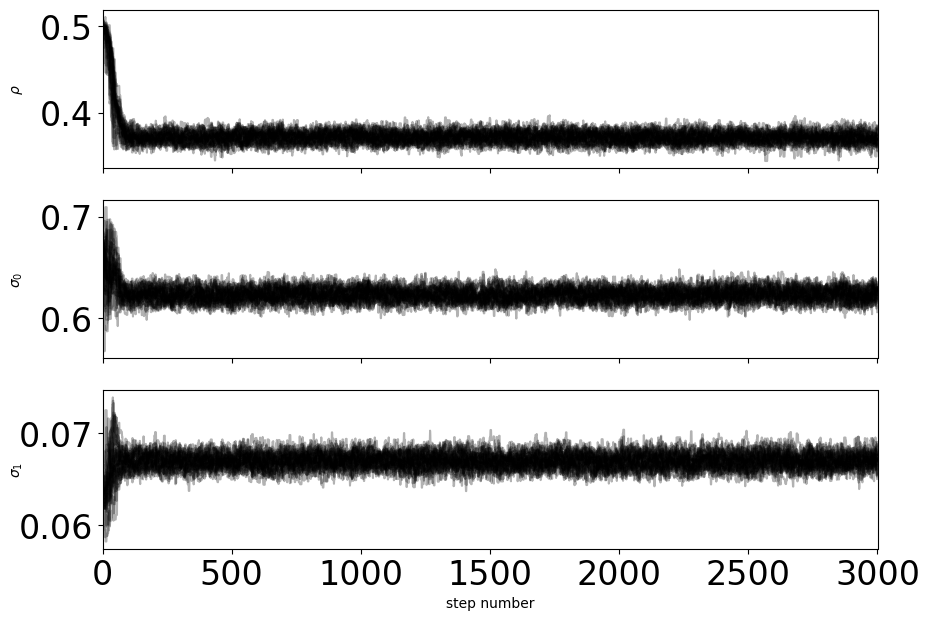

In [835]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True) 
samples1 = sampler.get_chain() #  Salvo nella variabile samples1 i valori assunti dai camminatori
                               #  nel campionamento della posterior distribution

labels = [r"$\rho$", r"$\sigma_0$", "$\sigma_1$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples1[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples1))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

L'andamento dei valori assunti dai walker in funzione del numero di step, indica che l'algoritmo è giunto a convergenza. Per analizzare i campioni generati, si deve tralasciare il trasiente (fase di burn in) necessario a raggiungere la distribuzione stazionaria. 

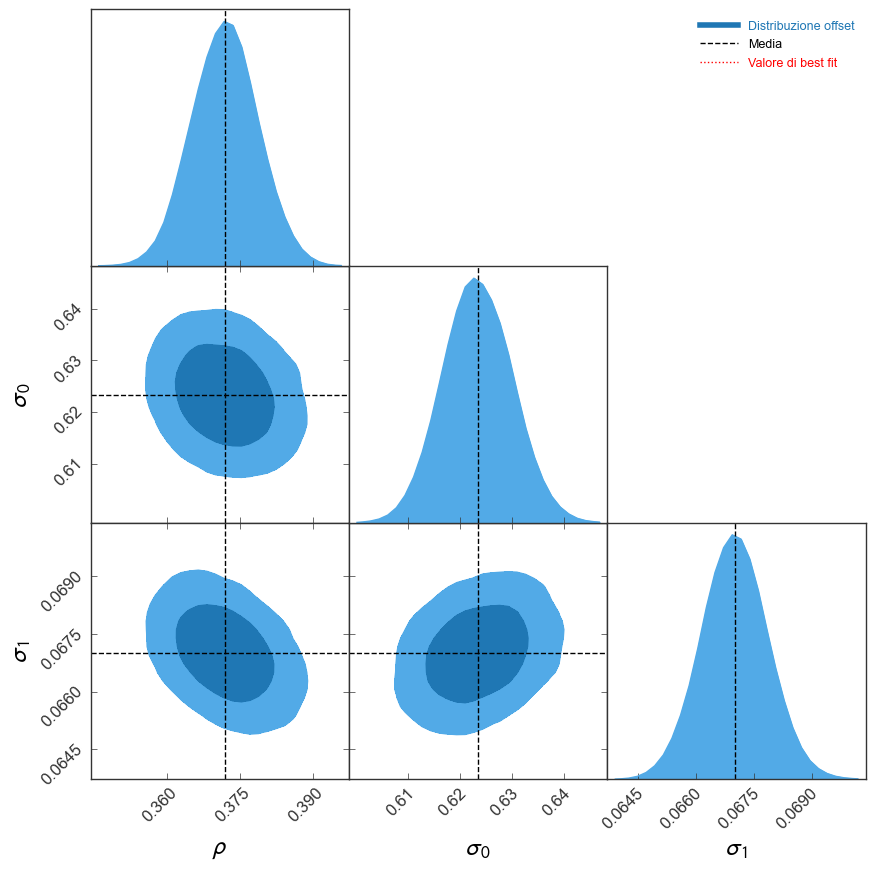

In [838]:
flat_samples = sampler.get_chain(discard=200, thin=2, flat=True) #Si definisce il campione, scartando
#i primi 200 step della catena come burn in, "appiattendo" la catena, e estraendo 1 valore ogni 2
means=np.mean(flat_samples, axis=0)
GTC = pygtc.plotGTC(chains=flat_samples,
                    paramNames=[r"$\rho$","$\sigma_0$","$\sigma_1$"], figureSize=10, 
                    customLabelFont={'family':'Arial', 'size':18},
                    customTickFont={'family':'Arial', 'size':12},truths=(means,best_fits),truthColors=('k','r'),
                    truthLabels=('Media','Valore di best fit'), chainLabels=['Distribuzione offset'])
                    #default: 68% and 95% contour levels

Si graficano le distributioni a posteriori marginalizzate dei parametri, evidenziando in nero la media e in rosso il valore di best fit. Si cotruiscono istogrammi due dimensionali per le coppie di parametri, con le curve di livello evidenziateche contengono il 68% e il 95% di probabilità. Gli assi principali delle ellissi non sono paralleli agli assi cartesiani, per cui già visivamente si intuisce che i parametri siano tra di loro correlati. In seguito si calcolano parametri significativi della distribuzione.  

In [841]:
label=['\u03C1','\u03C30','\u03C31']
std=np.std(flat_samples, axis=0)

for i in range(np.shape(flat_samples)[1]):
    best_fits[i]=flat_samples[np.argwhere(log_like==np.amax(log_like)),i] #i valori di best fit sono i 
    #parametri che hanno la massimizzano la posterior probability
    print(label[i], 'ha media: {0:.4f} e deviazione standard: {1:.4f}'.format(means[i],std[i]))
    print( 'il valore di best fit di',label[i],'è {0:.4g}'.format(  best_fits[i]))


corr=np.corrcoef(flat_samples.T)
print('\n')
print('Coefficienti di correlazione')
print('tra \u03C1 e \u03C30:',np.round(corr,2)[0][1]) 
print('tra \u03C1 e \u03C31:',np.round(corr,2)[0][2]) 
print('tra \u03C30 e \u03C31:',np.round(corr,2)[1][2]) 

ρ ha media: 0.3719 e deviazione standard: 0.0065
il valore di best fit di ρ è 0.3695
σ0 ha media: 0.6233 e deviazione standard: 0.0064
il valore di best fit di σ0 è 0.6207
σ1 ha media: 0.0670 e deviazione standard: 0.0008
il valore di best fit di σ1 è 0.06717


Coefficienti di correlazione
tra ρ e σ0: -0.21
tra ρ e σ1: -0.39
tra σ0 e σ1: 0.3




Per valutare la capacità del modello di riprodurre i dati, si sovrappone la distribuzione all'istogramma delle misure. Vengono utilizzate le stime della media dei parametri e dei parametri che massimizzano la probabilità. Le due curve si sovrappongono tra di loro. 

Si vuole propagare l'incertezza associata al modello, cioè l'incertezza sui parametri, nello spazio dei dati osservati. In particolare si procede estraendo un sottocampione di parametri dalla distribuzione a posteriori (già campionata con l'algoritmo emcee). Un modo per quantificare l'incertezza teorica sul valore della distribuzione, per ogni valore di massa, è calcolare il sedicesimo, cinquantesimo e ottantaquattresimo percentile delle curve ottenute per ogni set di parametri sottocampionati. Il cinquantesimo percentile corrisponde alla mediana (che si vede essere sovrapposta alle curve ottenute con la media e il valore di best fit dei parametri), e l'intervallo di confidenza è dato dai valori centrati sulla mediata che contengono il 68% della probabilità.

Si divide per la mediana (dei dati osservati e del modello teorico) per visualizzare meglio come si confrontano dati e modello.


Per valutare la bontà del fit bisogna definire una statistica di test.

Supponendo che la distribuzione degli offset sia descritta dal modello S15, se si ha a disposizione un campione sufficientemente grande di n misure indipendenti di offset per costruire un istogramma, si può assumere che il numero di eventi $n_k$ in un istogramma (con numero di bin N fissato) segua una distribuzione multinomiale, con valore di aspettazione $n \cdot p_k$ e deviazione standard $\sqrt{n p_k (1-p_k)}$, dove $p_k$ è la probabilità che il singolo evento cada nel k-esimo intervallo e si ottiene integrando la funzione di distribuzione. Se le $p_k$ sono sufficentemente piccole (inferiori al 10%), la correlazione tra gli eventi attesi in due intervalli diversi è trascurabile in prima approssimazione. Inoltre se i valori di aspettazione sono sufficentemente grandi (per esempio maggiori di 10) la distribuzione tende ad una multinormale, e la statistica 

$$t=\sum_{k=1}^N \frac{(n_k-\mu_k)^2}{\mu_k}$$
ha distribuzione di $\chi^2$ con N-1-l gradi di libertà, se l  il numero di parametri stimati dal campione di dati, e può essere usata come statistica di test per eseguire il test d'ipotesi che la distribuzione degli offset sia il modello considerato. 

Text(0, 0.5, 'Distribuzione di probabilità/Mediana')

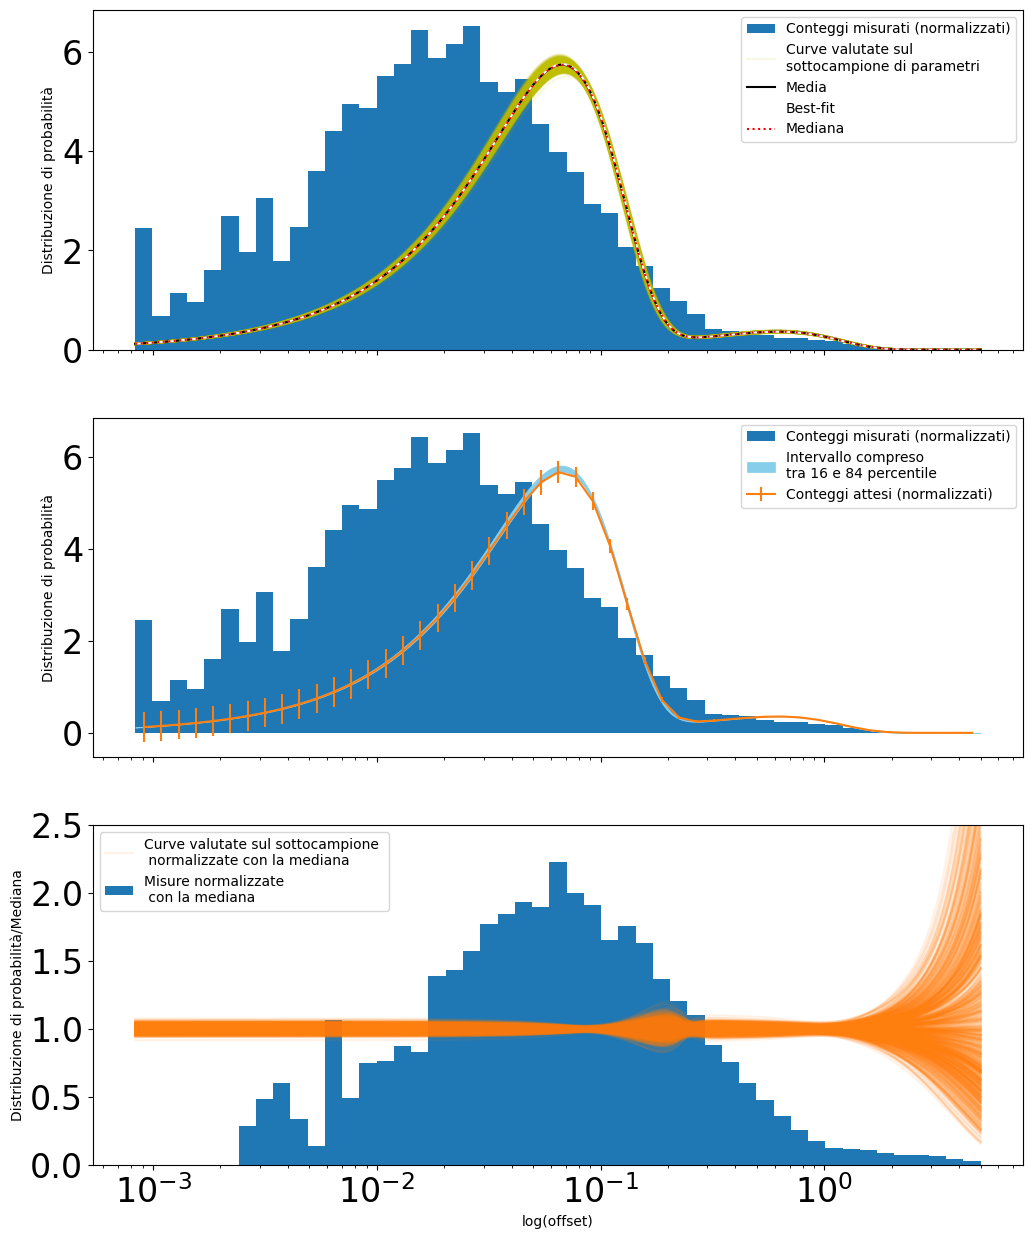

In [844]:
fig, ax = plt.subplots(3, figsize=(12, 15),sharex=True)

#x=np.arange(0,5,0.1)
#xarr=np.arange(0,5,0.005)

x=np.logspace(np.log10(np.min(data["BCG_offset_R500"])),np.log10(5), 50)
xarr=np.logspace(np.log10(np.min(data["BCG_offset_R500"])),np.log10(5), 1000)

yarr = np.zeros((len(xarr),Nsamples))
mean_relation=model_S15(means, xarr)

plt.xscale('log')

ax[0].hist(data["BCG_offset_R500"],x,label='Conteggi misurati (normalizzati)',density=True)


Nsamples =1000                                                           #per Nsamples volte
for i in range(Nsamples):                                                #estraggo un indice
    theta = flat_samples[ np.random.randint(len(flat_samples[:,0])) ,:]  #della catena 
    yarr[:,i] = model_S15(theta, xarr)
    if i==0:
        ax[0].plot(xarr, yarr[:,i],"y", label='Curve valutate sul \nsottocampione di parametri',alpha=0.1)
        ax[2].plot(xarr, model_S15(theta, xarr)/mean_relation, "C1",alpha=0.1, label='Curve valutate sul sottocampione \n normalizzate con la mediana')
    else:
        ax[0].plot(xarr,yarr[:,i], "y" ,alpha=0.1)
        ax[2].plot(xarr, model_S15(theta, xarr)/mean_relation, "C1",alpha=0.1)

ax[0].plot(xarr, model_S15(means, xarr), c="k",label='Media')
ax[0].plot(xarr, model_S15(best_fits, xarr), c="w",ls='--',label='Best-fit')
ax[0].plot(xarr, np.percentile(yarr,50,axis=1), c="r",ls=':',label='Mediana')



values1=ax[1].hist(data["BCG_offset_R500"],x,label='Conteggi misurati (normalizzati)',density=True)
ax[1].fill_between(xarr,np.percentile(yarr,16,axis=1),np.percentile(yarr,84,axis=1),color="skyblue",lw=0.5, label='Intervallo compreso \ntra 16 e 84 percentile')




log_bins=x
bin_centres=(log_bins[1:]+log_bins[:-1])/2
bin_width=log_bins[1:]-log_bins[:-1]
values=np.histogram(data["BCG_offset_R500"],log_bins)
n_tot=len(data["BCG_offset_R500"])
dx=xarr[1]-xarr[0]

errors=np.zeros(len(values[0]))
expected=np.zeros(len(values[0]))
p=np.zeros(len(values[0]))
normalization=sum(values[0])*bin_width


for i in range(len(values[0])):
    del_t=log_bins[i]+np.arange(100)*((log_bins[i+1]-log_bins[i])/100)
    p[i]=np.trapz(model_S15(best_fits,del_t),del_t)
    expected[i]=p[i]*n_tot
    errors[i]=np.sqrt(expected[i]*(1-p[i])) 
    
ax[1].errorbar(bin_centres, expected/normalization ,yerr=errors/normalization,label='Conteggi attesi (normalizzati)')

ax[2].hist(data["BCG_offset_R500"]/np.mean(data["BCG_offset_R500"]), x,density=True, label='Misure normalizzate \n con la mediana')
ax[2].set_ylim(0,2.5)


    
ax[0].legend()
ax[1].legend()
ax[2].legend()


ax[2].set_xlabel('log(offset)')

ax[0].set_ylabel('Distribuzione di probabilità')
ax[1].set_ylabel('Distribuzione di probabilità')
ax[2].set_ylabel('Distribuzione di probabilità/Mediana')


Si può già osservare che qualitativamente l'andamento dei dati non è descritto accuratamente dal modello. Per essere più quantitativi si calcola la statistica t, considerando solo gli intervalli dove valgono le ipotesi per cui in prima approssimazione essa segua una distribuzione di $\chi^2$. Gli intervalli rimanenti vanno trattati a parte.

In [846]:
print("Il numero di intervalli dell'istogramma costruito con il data set è {}.\nGli indici k, tali per cui il valore di aspettazione per i conteggi nell'intervallo k-esimo è maggiore di 10 sono {}.".format(len(values[0]), np.where(expected<10)[0]))
print("Gli indici k per cui la probabilià che un evento cada nell'intervallo k-esimo è minore di 0.1 sono", np.where(p>0.1)[0])
dof=len(values[0]) -len(np.where(expected<10)[0])-1
chisq=np.sum(np.where(expected<10,((values[0]-expected)/errors)**2, 0 ))/dof

alpha=0.05 #Livello di significatività con il quale si testa l'ipotesi che il modello sia un buon fit per i dati

print("Numero di gradi di libertà:", dof)
print('Chi quadro best fit:', chisq)
print('Valore critico (Livello di significatività=0.05):',chi2.ppf(1 - alpha, dof))
print('Chi quadro ridotto best fit =',chisq/dof)

Il numero di intervalli dell'istogramma costruito con il data set è 49.
Gli indici k, tali per cui il valore di aspettazione per i conteggi nell'intervallo k-esimo è maggiore di 10 sono [ 0  1  2  3  4  5  6  7  8  9 10 11 45 46 47 48].
Gli indici k per cui la probabilià che un evento cada nell'intervallo k-esimo è minore di 0.1 sono []
Numero di gradi di libertà: 32
Chi quadro best fit: 86070.85102919994
Valore critico (Livello di significatività=0.05): 46.194259520278486
Chi quadro ridotto best fit = 2689.714094662498


La statistica valutata sul campione è molto maggiore del valore critico, e l'ipotesi che la miscentering distribution sia descritta dal modello S15 deve essere rigettata con un livello di significatività del 5%. Infatti il valore del chi quadro ridotto e il modello non è un buon fit per i dati. 



### 4.2 Modello Z19
Si procede nello stesso modo per analizzare il campione, questa volta considerando il modello Z19 per la distribuzione degli offset.

In [849]:
np.random.seed(42)
nll = lambda *args: -log_posterior_Z19(*args)
initial = np.array([0.5, 1.,1.])
soln = minimize(nll, initial, args=data.BCG_offset_R500)
rho_bf, s0_bf, s1_bf = soln.x
pos = soln.x *(1+ 1e-2 * np.random.randn(32, 3))#definisco la posizione iniziale nello spazio
                                                  #dei parametri

nwalkers, ndim = pos.shape   # numero di walker e di parametri da fittare
sampler = emcee.EnsembleSampler( nwalkers, ndim, log_posterior_Z19, args=(data["BCG_offset_R500"],))
sampler.run_mcmc(pos, 3000, progress=True);


100%|██████████████████████████████████████| 3000/3000 [00:27<00:00, 107.84it/s]


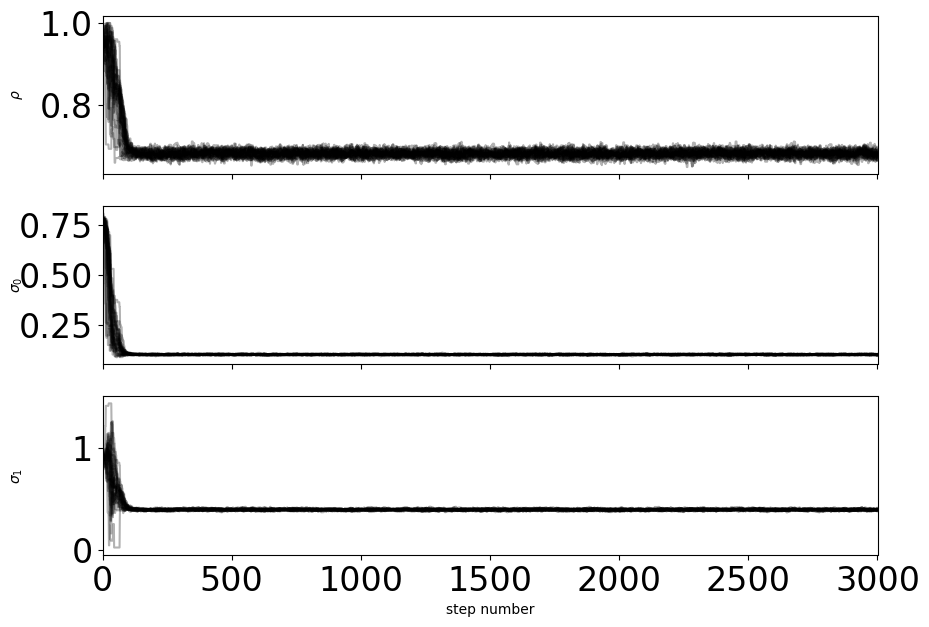

In [851]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples1 = sampler.get_chain() #  Salvo nella variabile samples1 i valori assunti dai camminatori
                               #  nel campionamento della posterior distribution
labels = [r"$\rho$", r"$\sigma_0$", "$\sigma_1$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples1[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples1))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");


L'andamento dei valori assunti dai walker in funzione del numero di step, indica che l'algoritmo è giunto a convergenza e per analizzare i campioni generati, si deve tralasciare la fase di burn in.

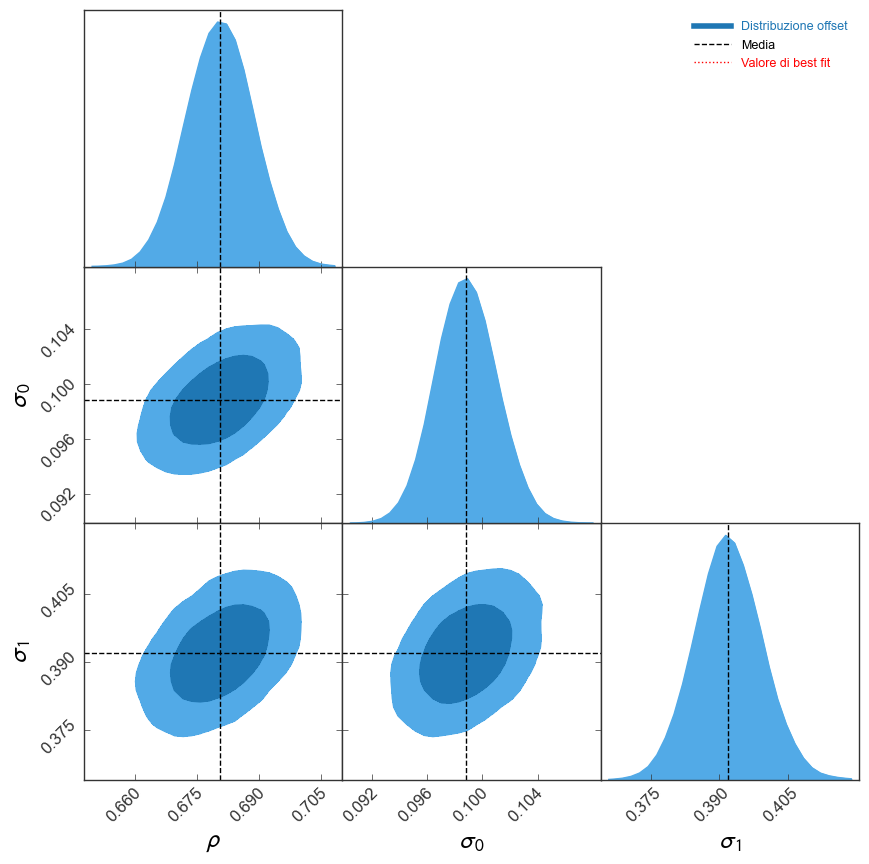

In [854]:
 flat_samples = sampler.get_chain(discard=200, thin=2, flat=True) #Si definisce il campione, scartando
#i primi 200 step della catena come burn in, "appiattendo" la catena, e estraendo 1 valore ogni 2
means=np.mean(flat_samples, axis=0)
GTC = pygtc.plotGTC(chains=flat_samples,
                    paramNames=[r"$\rho$","$\sigma_0$","$\sigma_1$"], figureSize=10, 
                    customLabelFont={'family':'Arial', 'size':18},
                    customTickFont={'family':'Arial', 'size':12},truths=(means,best_fits),truthColors=('k','r'),
                    truthLabels=('Media','Valore di best fit'), chainLabels=['Distribuzione offset'])
                    #default: 68% and 95% contour levels

In [856]:
label=['\u03C1','\u03C30','\u03C31']
std=np.std(flat_samples, axis=0)

for i in range(np.shape(flat_samples)[1]):
    best_fits1[i]=flat_samples[np.argwhere(log_like==np.amax(log_like)),i] #i valori di best fit sono i 
    #parametri che hanno la massimizzano la posterior probability
    print(label[i], 'ha media: {0:.4f} e deviazione standard: {1:.4f}'.format(means[i],std[i]))
    print( 'il valore di best fit di',label[i],'è {0:.4g}'.format(  best_fits1[i]))

    
corr=np.corrcoef(flat_samples.T)
print('\n')
print('Coefficienti di correlazione')
print('tra \u03C1 e \u03C30:',np.round(corr,2)[0][1]) 
print('tra \u03C1 e \u03C31:',np.round(corr,2)[0][2]) 
print('tra \u03C30 e \u03C31:',np.round(corr,2)[1][2]) 


ρ ha media: 0.6806 e deviazione standard: 0.0078
il valore di best fit di ρ è 0.6805
σ0 ha media: 0.0988 e deviazione standard: 0.0021
il valore di best fit di σ0 è 0.09868
σ1 ha media: 0.3920 e deviazione standard: 0.0072
il valore di best fit di σ1 è 0.392


Coefficienti di correlazione
tra ρ e σ0: 0.5
tra ρ e σ1: 0.46
tra σ0 e σ1: 0.4


49 49


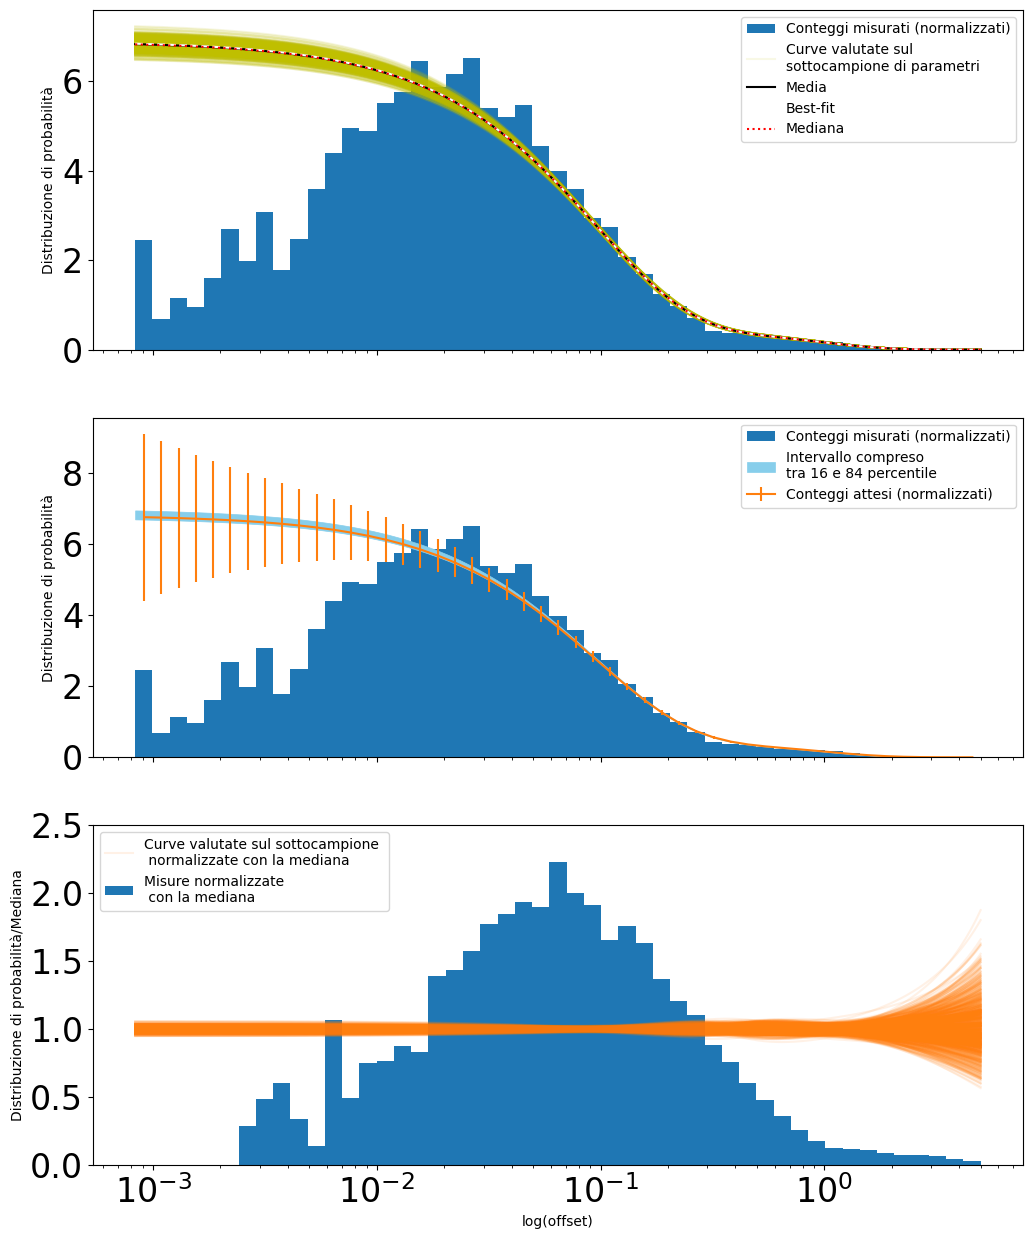

In [858]:
fig, ax = plt.subplots(3, figsize=(12, 15),sharex=True)

#x=np.arange(0,5,0.1)
#xarr=np.arange(0,5,0.005)

x=np.logspace(np.log10(np.min(data["BCG_offset_R500"])),np.log10(5), 50)
xarr=np.logspace(np.log10(np.min(data["BCG_offset_R500"])),np.log10(5), 1000)

yarr = np.zeros((len(xarr),Nsamples))
mean_relation=model_Z19(means, xarr)

plt.xscale('log')

ax[0].hist(data["BCG_offset_R500"],x,label='Conteggi misurati (normalizzati)',density=True)

Nsamples =1000                                                           #per Nsamples volte
for i in range(Nsamples):                                                #estraggo un indice
    theta = flat_samples[ np.random.randint(len(flat_samples[:,0])) ,:]  #della catena 
    yarr[:,i] = model_Z19(theta, xarr)
    if i==0:
        ax[0].plot(xarr, yarr[:,i],"y", label='Curve valutate sul \nsottocampione di parametri',
                   alpha=0.1)
        ax[2].plot(xarr, model_Z19(theta, xarr)/mean_relation, "C1",alpha=0.1, 
                   label='Curve valutate sul sottocampione \n normalizzate con la mediana')
    else:
        ax[0].plot(xarr,yarr[:,i], "y" ,alpha=0.1)
        ax[2].plot(xarr, model_Z19(theta, xarr)/mean_relation, "C1",alpha=0.1)

ax[0].plot(xarr, model_Z19(means, xarr), c="k",label='Media')
ax[0].plot(xarr, model_Z19(best_fits1, xarr), c="w",ls='--',label='Best-fit')
ax[0].plot(xarr, np.percentile(yarr,50,axis=1), c="r",ls=':',label='Mediana')



values1=ax[1].hist(data["BCG_offset_R500"],x,label='Conteggi misurati (normalizzati)',density=True)
ax[1].fill_between(xarr,np.percentile(yarr,16,axis=1),np.percentile(yarr,84,axis=1),color="skyblue",lw=0.5, label='Intervallo compreso \ntra 16 e 84 percentile')
log_bins=x
bin_centres=(log_bins[1:]+log_bins[:-1])/2
bin_width=log_bins[1:]-log_bins[:-1]
values=np.histogram(data["BCG_offset_R500"],log_bins)
n_tot=len(data["BCG_offset_R500"])
dx=xarr[1]-xarr[0]

errors1=np.zeros(len(values[0]))
expected1=np.zeros(len(values[0]))
p=np.zeros(len(values[0]))
normalization=sum(values[0])*bin_width


for i in range(len(values[0])):
    del_t=log_bins[i]+np.arange(100)*((log_bins[i+1]-log_bins[i])/100)
    p[i]=np.trapz(model_Z19(best_fits1,del_t),del_t)
    expected1[i]=p[i]*n_tot
    errors1[i]=np.sqrt(expected1[i]*(1-p[i])) 
    
ax[1].errorbar(bin_centres, expected1/normalization ,yerr=errors1/normalization,label='Conteggi attesi (normalizzati)')

ax[2].hist(data["BCG_offset_R500"]/np.mean(data["BCG_offset_R500"]), x,density=True, label='Misure normalizzate \n con la mediana')
ax[2].set_ylim(0,2.5)


    
ax[0].legend()
ax[1].legend()
ax[2].legend()


ax[2].set_xlabel('log(offset)')

ax[0].set_ylabel('Distribuzione di probabilità')
ax[1].set_ylabel('Distribuzione di probabilità')
ax[2].set_ylabel('Distribuzione di probabilità/Mediana')
print(len(bin_centres), len(expected))

In [904]:
print("Il numero di intervalli dell'istogramma costruito con il data set è {}.\nGli indici k, tali per cui il valore di aspettazione per i conteggi nell'intervallo k-esimo è maggiore di 10 sono {}.".format(len(values[0]), np.where(expected1<10)[0]))
print("Gli indici k per cui la probabilià che un evento cada nell'intervallo k-esimo è minore di 0.1 sono", np.where(p>0.1)[0])
dof=len(values[0]) -len(np.where(expected1<10)[0])-1
chisq=np.sum(np.where(expected1>=10,((values[0]-expected1)/errors1)**2, 0 ))

alpha=0.05 #Livello di significatività con il quale si testa l'ipotesi che il modello sia un buon fit per i dati

print("Numero di gradi di libertà:", dof)
print('Chi quadro best fit:', chisq)
print('Valore critico (Livello di significatività=0.05):',chi2.ppf(1 - alpha, dof))
print('Chi quadro ridotto best fit =',chisq/dof)
print("\nSeguono gli indici trascurati, e lo scarto tra il valore atteso e quello misurato, tutto diviso per la deviazione standard")

for i in np.where(expected1<10)[0]:
    print(i,":",(values[0][i]-expected1[i])/errors1[i])


Il numero di intervalli dell'istogramma costruito con il data set è 49.
Gli indici k, tali per cui il valore di aspettazione per i conteggi nell'intervallo k-esimo è maggiore di 10 sono [ 0  1 46 47 48].
Gli indici k per cui la probabilià che un evento cada nell'intervallo k-esimo è minore di 0.1 sono [0 1 2]
Numero di gradi di libertà: 43
Chi quadro best fit: 258.81999330146357
Valore critico (Livello di significatività=0.05): 59.303512026899796
Chi quadro ridotto best fit = 6.019069611661943

Seguono gli indici trascurati, e lo scarto tra il valore atteso e quello misurato, tutto diviso per la deviazione standard
0 : -1.8340064758259573
1 : -2.8238266927656825
46 : 0.23664101548163374
47 : 0.9607238823608155
48 : 0.6023209500192889


Anche in questo caso, l'ipotesi che la miscentering distribution sia descritta dal modello Z19 va rigettata con un livello di significatività del 5%. In ogni caso il valore del chi quadro ridotto è molto più vicino ad 1 del caso precedente, e il valore della statistica non è così tanto supeiore al valor critico rispetto a prima. Questa osservazione è coerente con il fatto che la curva attesa per questo modello descrive meglio l'andamento dei dati. Per quanto riguarda le code i valori attesi e osservati distano per meno di 3 deviazioni standard (tuttavia, la variabile non ha una distribuzione gaussiana in questi casi).

Text(0.5, 1.0, 'Confronto tra i due modelli proposti e i dati misurati')

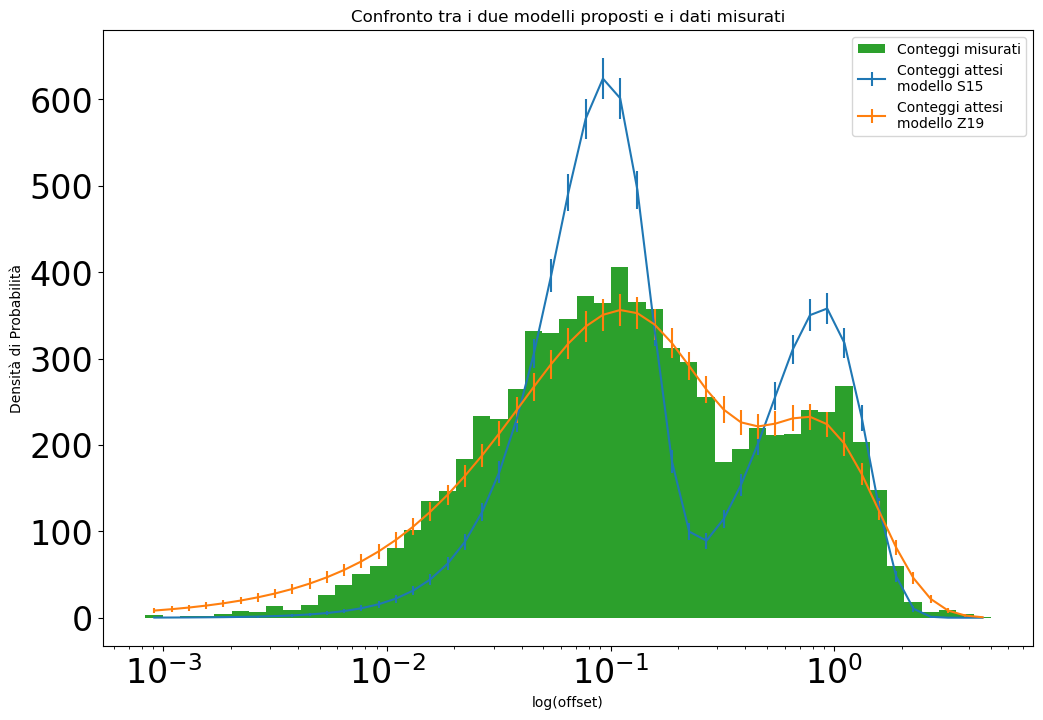

In [913]:
plt.figure(figsize=(12, 8))
plt.errorbar(bin_centres, expected, yerr=errors, label='Conteggi attesi \nmodello S15')
plt.errorbar(bin_centres, expected1, yerr=errors1, label='Conteggi attesi \nmodello Z19')
plt.hist(data["BCG_offset_R500"],x,label='Conteggi misurati')

plt.legend()
plt.xscale('log')
plt.xlabel("log(offset)")
plt.ylabel("Densità di Probabilità")
plt.title("Confronto tra i due modelli proposti e i dati misurati")



In conclusione, il secondo modello descrive meglio il dataset a disposizione. Per migliorare ulteriormente il fit dei dati si potrebbero introdurre nuovi parametri nella distribuzione, in modo da permettere alla funzione di adattarsi meglio ai dati.